In [ ]:
!pip install -qq -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 8.6 MB/s eta 0:00:00


## Setup

In [ ]:
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import tensorflow_datasets as tfds

# Setting seed for reproducibiltiy
SEED = 42
keras.utils.set_random_seed(SEED)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Prepare the data

## Tiny-ImageNet

In [ ]:
from google.colab import drive

drive.mount( '/content/drive', force_remount=True )

Mounted at /content/drive


In [ ]:
! git clone https://github.com/seshuad/IMagenet
! ls 'IMagenet/tiny-imagenet-200/'

Cloning into 'IMagenet'...
remote: Enumerating objects: 120594, done.
remote: Total 120594 (delta 0), reused 0 (delta 0), pack-reused 120594
Receiving objects: 100% (120594/120594), 212.68 MiB | 48.10 MiB/s, done.
Resolving deltas: 100% (1115/1115), done.
Updating files: 100% (120206/120206), done.
test  train  val  wnids.txt  words.txt


In [ ]:
NUM_CLASSES = 200
INPUT_SHAPE = (64, 64, 3)

import time
import scipy.ndimage as nd
import imageio
import numpy as np

path = 'IMagenet/tiny-imagenet-200/'

def get_id_dictionary():
    id_dict = {}
    for i, line in enumerate(open( path + 'wnids.txt', 'r')):
        id_dict[line.replace('\n', '')] = i
    return id_dict
  
def get_class_to_id_dict():
    id_dict = get_id_dictionary()
    all_classes = {}
    result = {}
    for i, line in enumerate(open( path + 'words.txt', 'r')):
        n_id, word = line.split('\t')[:2]
        all_classes[n_id] = word
    for key, value in id_dict.items():
        result[value] = (key, all_classes[key])      
    return result

def get_data(id_dict):
    print('starting loading data')
    train_data, test_data = [], []
    train_labels, test_labels = [], []
    t = time.time()
    for key, value in id_dict.items():
        train_data += [imageio.imread( path + 'train/{}/images/{}_{}.JPEG'.format(key, key, str(i)), pilmode='RGB') for i in range(500)]
        train_labels_ = np.array([[0]*200]*500)
        train_labels_[:, value] = 1
        train_labels += train_labels_.tolist()

    for line in open( path + 'val/val_annotations.txt'):
        img_name, class_id = line.split('\t')[:2]
        test_data.append(imageio.imread( path + 'val/images/{}'.format(img_name) ,pilmode='RGB'))
        test_labels_ = np.array([[0]*200])
        test_labels_[0, id_dict[class_id]] = 1
        test_labels += test_labels_.tolist()

    print('finished loading data, in {} seconds'.format(time.time() - t))
    return np.array(train_data), np.array(train_labels), np.array(test_data), np.array(test_labels)
  
x_train, y_train, x_test, y_test = get_data(get_id_dictionary())

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

starting loading data


<ipython-input-5-92475de8ba90>:34: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  train_data += [imageio.imread( path + 'train/{}/images/{}_{}.JPEG'.format(key, key, str(i)), pilmode='RGB') for i in range(500)]
<ipython-input-5-92475de8ba90>:41: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  test_data.append(imageio.imread( path + 'val/images/{}'.format(img_name) ,pilmode='RGB'))


finished loading data, in 56.053492069244385 seconds
x_train shape: (100000, 64, 64, 3) - y_train shape: (100000, 200)
x_test shape: (10000, 64, 64, 3) - y_test shape: (10000, 200)


In [ ]:
# We need to transfer the format of labels so that they fit our ViT model
y_train = np.argmax(y_train, axis=1)
y_train = y_train[:,np.newaxis]
y_test = np.argmax(y_test, axis=1)
y_test = y_test[:,np.newaxis]
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

y_train shape: (100000, 1)
y_test shape: (10000, 1)


## CIFAR10

In [ ]:
NUM_CLASSES = 10
INPUT_SHAPE = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

170498071/170498071 [==============================] - 3s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## CIFAR100

In [ ]:
NUM_CLASSES = 100
INPUT_SHAPE = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

169001437/169001437 [==============================] - 6s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## TF_Flowers

In [ ]:
RESOLUTION = 224
BATCH_SIZE = 256
AUTO = tf.data.AUTOTUNE
NUM_CLASSES = 5
INPUT_SHAPE = (224, 224, 3)

def preprocess_dataset(is_training=True):
    def fn(image, label):
        if is_training:
            # Resize to a bigger spatial resolution and take the random
            # crops.
            image = tf.image.resize(image, (RESOLUTION + 20, RESOLUTION + 20))
            image = tf.image.random_crop(image, (RESOLUTION, RESOLUTION, 3))
            image = tf.image.random_flip_left_right(image)
        else:
            image = tf.image.resize(image, (RESOLUTION, RESOLUTION))
        label = tf.one_hot(label, depth=NUM_CLASSES)
        return image, label

    return fn


def prepare_dataset(dataset, is_training=True):
    if is_training:
        dataset = dataset.shuffle(BATCH_SIZE * 10)
    dataset = dataset.map(preprocess_dataset(is_training), num_parallel_calls=AUTO)
    return dataset.batch(BATCH_SIZE).prefetch(AUTO)


train_dataset, test_dataset = tfds.load(
    "tf_flowers", split=["train[:90%]", "train[90%:]"], as_supervised=True
)
num_train = train_dataset.cardinality()
num_test = test_dataset.cardinality()
print(f"Number of training examples: {num_train}")
print(f"Number of testing examples: {num_test}")

train_dataset = prepare_dataset(train_dataset, is_training=True)
test_dataset = prepare_dataset(test_dataset, is_training=False)

Number of training examples: 3303
Number of testing examples: 367


In [ ]:
import numpy as np
train_np = tfds.as_numpy(train_dataset)
train_np_image = []
train_np_label = []
for i, token in enumerate(train_np):
  if i == 0:
    train_np_image = token[0]
    train_np_label = np.argmax(token[1], axis=1)
  else:
    train_np_image = np.concatenate((train_np_image, token[0]),axis=0)
    train_np_label = np.concatenate((train_np_label, np.argmax(token[1], axis=1)),axis=0)
x_train = np.array(train_np_image).reshape((-1,224,224,3))
y_train = np.array(train_np_label).reshape((-1,1))

test_np = tfds.as_numpy(test_dataset)
test_np_image = []
test_np_label = []
for i, token in enumerate(test_np):
  if i == 0:
    test_np_image = token[0]
    test_np_label = np.argmax(token[1], axis=1)
  else:
    test_np_image = np.concatenate((test_np_image, token[0]),axis=0)
    test_np_label = np.concatenate((test_np_label, np.argmax(token[1], axis=1)),axis=0)
x_test = np.array(test_np_image).reshape((-1,224,224,3))
y_test = np.array(test_np_label).reshape((-1,1))

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (3303, 224, 224, 3) - y_train shape: (3303, 1)
x_test shape: (367, 224, 224, 3) - y_test shape: (367, 1)


## Configure the hyperparameters

In [ ]:
# DATA
BUFFER_SIZE = 512
BATCH_SIZE = 256

# AUGMENTATION
IMAGE_SIZE = 72
PATCH_SIZE = 6
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

# OPTIMIZER
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001

# TRAINING
EPOCHS = 50

# ARCHITECTURE
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 8
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
MLP_HEAD_UNITS = [2048, 1024]

## Data augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

## Implement Rotated Patch Tokenization

In [ ]:
def rand_rotate(input_image, max_angle, min_angle):
  random_angles = np.random.uniform(low = min_angle , high = max_angle)
  rotated_image = tfa.image.rotate(images = input_image, angles=random_angles)
  return rotated_image

In [ ]:
# make a test on whether rand_rotate works well
images = x_train[0:10]
resized_image = tf.image.resize(
    tf.convert_to_tensor(images), size=(IMAGE_SIZE, IMAGE_SIZE)
)
print(rand_rotate(resized_image, np.pi / 14, np.pi / 20).shape)

(10, 72, 72, 3)


In [ ]:
class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        num_patches=NUM_PATCHES,
        projection_dim=PROJECTION_DIM,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to switch to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.min_angle_abs = np.pi / 20
        self.max_angle_abs = np.pi / 14
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def crop_shift_rotate_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        elif mode == "right-down":
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch
        elif mode == "rotate-anticlock":
            max_angle = self.max_angle_abs
            min_angle = self.min_angle_abs
        elif mode == "rotate-clock":
            max_angle = -self.min_angle_abs
            min_angle = -self.max_angle_abs
        
        if 'rotate' in mode:
            return rand_rotate(images, max_angle, min_angle)
        else: 
            # Crop the shifted images and pad them
            crop = tf.image.crop_to_bounding_box(
                images,
                offset_height=crop_height,
                offset_width=crop_width,
                target_height=self.image_size - self.half_patch,
                target_width=self.image_size - self.half_patch,
            )
            shift_pad = tf.image.pad_to_bounding_box(
                crop,
                offset_height=shift_height,
                offset_width=shift_width,
                target_height=self.image_size,
                target_width=self.image_size,
            )
            return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = tf.concat(
                [
                    images,
                    self.crop_shift_rotate_pad(images, mode="left-up"),
                    self.crop_shift_rotate_pad(images, mode="left-down"),
                    self.crop_shift_rotate_pad(images, mode="right-up"),
                    self.crop_shift_rotate_pad(images, mode="right-down"),
                    self.crop_shift_rotate_pad(images, mode="rotate-anticlock"),
                    self.crop_shift_rotate_pad(images, mode="rotate-clock"),
                ],
                axis=-1,
            )
        # Patchify the images and flatten it
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)


0.22108157012263485


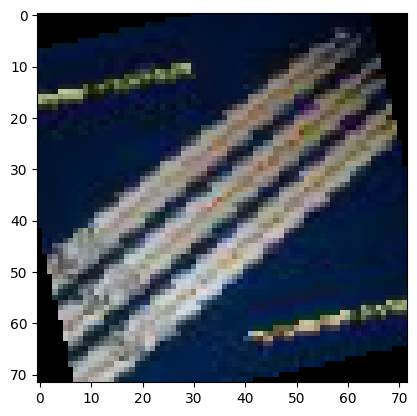

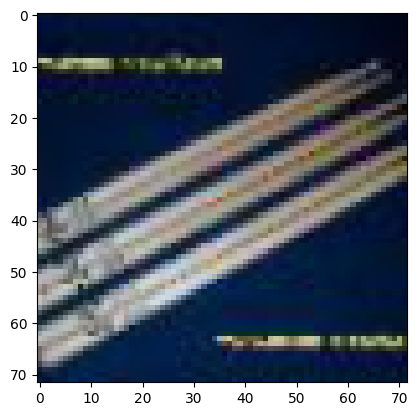

(1, 72, 72, 3)


In [ ]:
# visualize the rotate part
random_angles = np.random.uniform(low = np.pi/20 , high = np.pi/14)
print(random_angles)
image = x_train[np.random.choice(range(x_train.shape[0]))]
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(IMAGE_SIZE, IMAGE_SIZE)
)
rotated_image = tfa.image.rotate(images = tf.squeeze(resized_image/255.0), angles=random_angles)
plt.imshow(rotated_image)
plt.show()
plt.imshow(tf.squeeze(resized_image/255.0))
plt.show()
print(tf.expand_dims(rotated_image,axis=0).shape)

### Visualize the patches

ORIGINAL


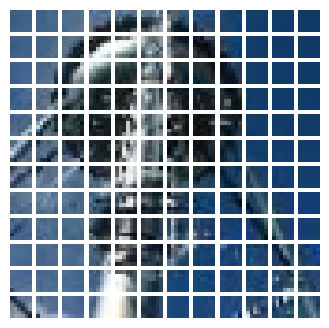

LEFT-UP


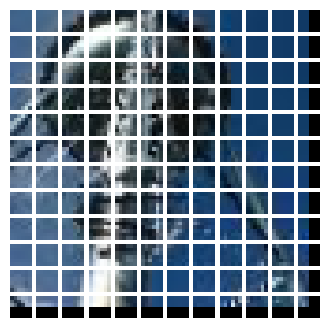

LEFT-DOWN


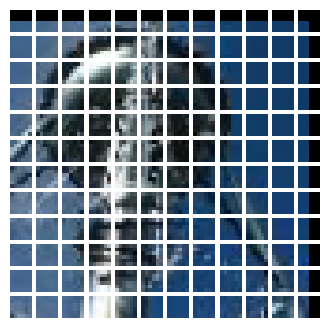

RIGHT-UP


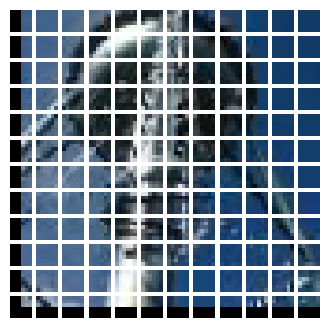

RIGHT-DOWN


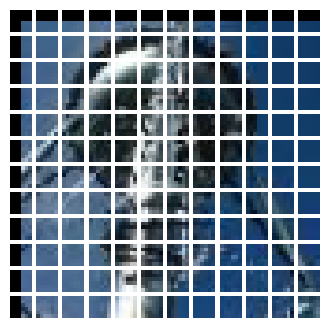

rotate-anticlock


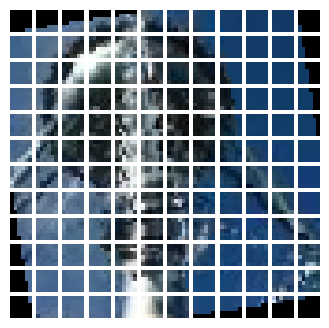

rotate-clock


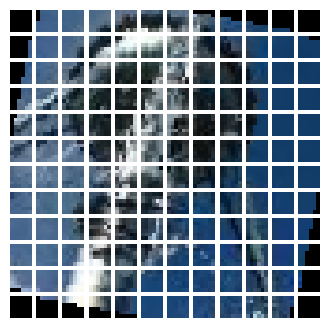

In [ ]:
# Get a random image from the training dataset
# and resize the image
image = x_train[np.random.choice(range(x_train.shape[0]))]
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(IMAGE_SIZE, IMAGE_SIZE)
)

# Vanilla patch maker: This takes an image and divides into
# patches as in the original ViT paper
(token, patch) = ShiftedPatchTokenization(vanilla=True)(resized_image / 255.0)
(token, patch) = (token[0], patch[0])

# Shifted Patch Tokenization: This layer takes the image, shifts it
# diagonally and then extracts patches from the concatinated images
(token, patch) = ShiftedPatchTokenization(vanilla=False)(resized_image / 255.0)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
shifted_images = ["ORIGINAL", "LEFT-UP", "LEFT-DOWN","RIGHT-UP", "RIGHT-DOWN", "rotate-anticlock", "rotate-clock"]
#shifted_images = ["ORIGINAL", "LEFT-UP", "LEFT-DOWN", "RIGHT-UP", "RIGHT-DOWN"]
for index, name in enumerate(shifted_images):
    print(name)
    count = 1
    plt.figure(figsize=(4, 4))
    for row in range(n):
        for col in range(n):
            plt.subplot(n, n, count)
            count = count + 1
            image = tf.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 7 * 3))
            plt.imshow(image[..., 3 * index : 3 * index + 3])
            plt.axis("off")
    plt.show()

## Implement the patch encoding layer

This layer accepts projected patches and then adds positional
information to them.

In [ ]:

class PatchEncoder(layers.Layer):
    def __init__(
        self, num_patches=NUM_PATCHES, projection_dim=PROJECTION_DIM, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches


## Implement the MLP

In [ ]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


# Build the diagonal attention mask
diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)

## Build the ViT

In [ ]:

def create_vit_classifier(vanilla=False):
    inputs = layers.Input(shape=INPUT_SHAPE)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    (tokens, _) = ShiftedPatchTokenization(vanilla=vanilla)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder()(tokens)

    # Create multiple layers of the Transformer block.
    for _ in range(TRANSFORMER_LAYERS):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=MLP_HEAD_UNITS, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(NUM_CLASSES)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


## Compile, train, and evaluate the mode

## Tiny_ImageNet

In [ ]:
# Some code is taken from:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2.
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super().__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


def run_experiment(model):
    total_steps = int((len(x_train) / BATCH_SIZE) * EPOCHS)
    warmup_epoch_percentage = 0.10
    warmup_steps = int(total_steps * warmup_epoch_percentage)
    scheduled_lrs = WarmUpCosine(
        learning_rate_base=LEARNING_RATE,
        total_steps=total_steps,
        warmup_learning_rate=0.0,
        warmup_steps=warmup_steps,
    )

    optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_split=0.1,
    )
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

# Run experiments with Rot-ViT
vit_sl = create_vit_classifier(vanilla=False)
history = run_experiment(vit_sl)

Epoch 1/50
352/352 [==============================] - 42s 84ms/step - loss: 5.1503 - accuracy: 0.0180 - top-5-accuracy: 0.0730 - val_loss: 10.8497 - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.0000e+00
Epoch 2/50
352/352 [==============================] - 28s 79ms/step - loss: 4.8028 - accuracy: 0.0365 - top-5-accuracy: 0.1339 - val_loss: 13.8718 - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.0000e+00
Epoch 3/50
352/352 [==============================] - 28s 79ms/step - loss: 4.6508 - accuracy: 0.0506 - top-5-accuracy: 0.1727 - val_loss: 14.4913 - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.0000e+00
Epoch 4/50
352/352 [==============================] - 28s 79ms/step - loss: 4.5314 - accuracy: 0.0631 - top-5-accuracy: 0.2025 - val_loss: 16.0860 - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.0000e+00
Epoch 5/50
352/352 [==============================] - 28s 79ms/step - loss: 4.3869 - accuracy: 0.0793 - top-5-accuracy: 0.2425 - val_loss: 16.8679 - val_accuracy: 0.0000e+0

## CIFAR10

In [ ]:
# Some code is taken from:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2.
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super().__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


def run_experiment(model):
    total_steps = int((len(x_train) / BATCH_SIZE) * EPOCHS)
    warmup_epoch_percentage = 0.10
    warmup_steps = int(total_steps * warmup_epoch_percentage)
    scheduled_lrs = WarmUpCosine(
        learning_rate_base=LEARNING_RATE,
        total_steps=total_steps,
        warmup_learning_rate=0.0,
        warmup_steps=warmup_steps,
    )

    optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_split=0.1,
    )
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

vit_sl = create_vit_classifier(vanilla=False)
history = run_experiment(vit_sl)

Epoch 1/50
176/176 [==============================] - 27s 86ms/step - loss: 2.0176 - accuracy: 0.3248 - top-5-accuracy: 0.8126 - val_loss: 1.5445 - val_accuracy: 0.4456 - val_top-5-accuracy: 0.9028
Epoch 2/50
176/176 [==============================] - 14s 77ms/step - loss: 1.5907 - accuracy: 0.4267 - top-5-accuracy: 0.8904 - val_loss: 1.3853 - val_accuracy: 0.5190 - val_top-5-accuracy: 0.9322
Epoch 3/50
176/176 [==============================] - 14s 77ms/step - loss: 1.4580 - accuracy: 0.4757 - top-5-accuracy: 0.9152 - val_loss: 1.2519 - val_accuracy: 0.5586 - val_top-5-accuracy: 0.9512
Epoch 4/50
176/176 [==============================] - 14s 77ms/step - loss: 1.3573 - accuracy: 0.5143 - top-5-accuracy: 0.9296 - val_loss: 1.1550 - val_accuracy: 0.6066 - val_top-5-accuracy: 0.9552
Epoch 5/50
176/176 [==============================] - 14s 77ms/step - loss: 1.2554 - accuracy: 0.5564 - top-5-accuracy: 0.9436 - val_loss: 1.0800 - val_accuracy: 0.6194 - val_top-5-accuracy: 0.9634
Epoch 6/50

## CIFAR100

In [ ]:
# Some code is taken from:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2.
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super().__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


def run_experiment(model):
    total_steps = int((len(x_train) / BATCH_SIZE) * EPOCHS)
    warmup_epoch_percentage = 0.10
    warmup_steps = int(total_steps * warmup_epoch_percentage)
    scheduled_lrs = WarmUpCosine(
        learning_rate_base=LEARNING_RATE,
        total_steps=total_steps,
        warmup_learning_rate=0.0,
        warmup_steps=warmup_steps,
    )

    optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_split=0.1,
    )
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

vit_sl = create_vit_classifier(vanilla=False)
history = run_experiment(vit_sl)

Epoch 1/50
176/176 [==============================] - 36s 142ms/step - loss: 4.4835 - accuracy: 0.0448 - top-5-accuracy: 0.1555 - val_loss: 3.9566 - val_accuracy: 0.1090 - val_top-5-accuracy: 0.3202
Epoch 2/50
176/176 [==============================] - 23s 132ms/step - loss: 3.9880 - accuracy: 0.0954 - top-5-accuracy: 0.2839 - val_loss: 3.6675 - val_accuracy: 0.1602 - val_top-5-accuracy: 0.3890
Epoch 3/50
176/176 [==============================] - 23s 131ms/step - loss: 3.7824 - accuracy: 0.1238 - top-5-accuracy: 0.3411 - val_loss: 3.4260 - val_accuracy: 0.1940 - val_top-5-accuracy: 0.4574
Epoch 4/50
176/176 [==============================] - 23s 131ms/step - loss: 3.6321 - accuracy: 0.1452 - top-5-accuracy: 0.3881 - val_loss: 3.3041 - val_accuracy: 0.2132 - val_top-5-accuracy: 0.4832
Epoch 5/50
176/176 [==============================] - 23s 131ms/step - loss: 3.5137 - accuracy: 0.1679 - top-5-accuracy: 0.4211 - val_loss: 3.2151 - val_accuracy: 0.2364 - val_top-5-accuracy: 0.5162
Epoch

## TF_Flowers



In [ ]:
# Some code is taken from:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2.
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super().__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


def run_experiment(model):
    total_steps = int((len(x_train) / BATCH_SIZE) * EPOCHS)
    warmup_epoch_percentage = 0.10
    warmup_steps = int(total_steps * warmup_epoch_percentage)
    scheduled_lrs = WarmUpCosine(
        learning_rate_base=LEARNING_RATE,
        total_steps=total_steps,
        warmup_learning_rate=0.0,
        warmup_steps=warmup_steps,
    )

    optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_split=0.1,
    )
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

vit_sl = create_vit_classifier(vanilla=False)
history = run_experiment(vit_sl)

Epoch 1/50
12/12 [==============================] - 17s 360ms/step - loss: 4.8205 - accuracy: 0.2971 - top-5-accuracy: 1.0000 - val_loss: 1.5774 - val_accuracy: 0.3746 - val_top-5-accuracy: 1.0000
Epoch 2/50
12/12 [==============================] - 2s 191ms/step - loss: 1.9064 - accuracy: 0.3614 - top-5-accuracy: 1.0000 - val_loss: 1.4045 - val_accuracy: 0.3776 - val_top-5-accuracy: 1.0000
Epoch 3/50
12/12 [==============================] - 2s 190ms/step - loss: 1.4893 - accuracy: 0.3937 - top-5-accuracy: 1.0000 - val_loss: 1.3234 - val_accuracy: 0.4653 - val_top-5-accuracy: 1.0000
Epoch 4/50
12/12 [==============================] - 2s 194ms/step - loss: 1.3467 - accuracy: 0.4344 - top-5-accuracy: 1.0000 - val_loss: 1.2857 - val_accuracy: 0.4411 - val_top-5-accuracy: 1.0000
Epoch 5/50
12/12 [==============================] - 2s 190ms/step - loss: 1.3215 - accuracy: 0.4448 - top-5-accuracy: 1.0000 - val_loss: 1.2689 - val_accuracy: 0.4773 - val_top-5-accuracy: 1.0000
Epoch 6/50
12/12 [=